# Merge Dataset Train & Valid

In [1]:
import os
import shutil
from pathlib import Path

base_dir = Path('/kaggle/input/chest-ctscan-images/Data')
output_dir = Path('datasetMerge')

canonical_classes = [
    'adenocarcinoma',
    'large.cell.carcinoma',
    'normal',
    'squamous.cell.carcinoma'
]

output_dir.mkdir(exist_ok=True)

for class_name in canonical_classes:
    (output_dir / class_name).mkdir(exist_ok=True)

total_files_copied = 0

for source_class_dir in base_dir.glob('*/*'):
    if not source_class_dir.is_dir():
        continue
    
    raw_name = source_class_dir.name
    
    target_class_name = next(
        (name for name in canonical_classes if raw_name.startswith(name)),
        None
    )
    
    if not target_class_name:
        continue
    
    parent_dir_name = source_class_dir.parent.name.lower()
    if 'train' not in parent_dir_name and 'valid' not in parent_dir_name:
        continue

    destination_path = output_dir / target_class_name
    destination_path.mkdir(exist_ok=True)
    
    for source_file in source_class_dir.glob('*'):
        if source_file.is_file():
            dest_file = destination_path / source_file.name
            
            if dest_file.exists():
                continue
            
            shutil.copy2(source_file, dest_file)
            total_files_copied += 1

# ============================================================================
# RINGKASAN HASIL
# ============================================================================
print("\n" + "=" * 70)
print("PROSES SELESAI!")
print("=" * 70)
print(f"Total file yang berhasil disalin: {total_files_copied}")
print(f"Semua data tergabung di folder: '{output_dir}'")

# Statistik per kelas
print("\n" + "=" * 70)
print("Distribusi Data per Kelas (TRAIN + VALID Merged):")
print("=" * 70)

total_unique_files = 0
for class_name in canonical_classes:
    class_path = output_dir / class_name
    if class_path.exists():
        num_files = len(list(class_path.glob('*')))
        total_unique_files += num_files
        print(f"  {class_name:30s}: {num_files:4d} images")

print("-" * 70)
print(f"  {'TOTAL FILES':30s}: {total_unique_files:4d} images")
print("=" * 70)


PROSES SELESAI!
Total file yang berhasil disalin: 0
Semua data tergabung di folder: 'datasetMerge'

Distribusi Data per Kelas (TRAIN + VALID Merged):
  adenocarcinoma                :  218 images
  large.cell.carcinoma          :  136 images
  normal                        :  151 images
  squamous.cell.carcinoma       :  170 images
----------------------------------------------------------------------
  TOTAL FILES                   :  675 images


# Splitting dataset "datasetMerge"

In [2]:
!pip install split-folders -q
import splitfolders
from pathlib import Path

input_folder = 'datasetMerge'
output_folder = 'datasetSplit'

splitfolders.ratio(
    input_folder, 
    output=output_folder, 
    seed=42,
    ratio=(0.8, 0.2),  # 80% train, 20% val
    group_prefix=None,
    move=False
)

print("Data splitting selesai!")
print(f"Output folder: {output_folder}")

def verify_split(base_path):
    """Verifikasi distribusi data setelah splitting"""
    splits = ['train', 'val']
    
    print("\n" + "="*70)
    print("VERIFIKASI HASIL SPLITTING (80:20)")
    print("="*70)
    
    total_all = 0
    split_totals = {}
    
    for split in splits:
        split_path = Path(base_path) / split
        if not split_path.exists():
            continue
            
        print(f"\n{split.upper()} SET:")
        print("-"*70)
        
        total = 0
        for class_dir in sorted(split_path.iterdir()):
            if class_dir.is_dir():
                count = len(list(class_dir.glob('*')))
                total += count
                print(f"  {class_dir.name:30s}: {count:3d} images")
        
        split_totals[split] = total
        total_all += total
        print(f"  {'TOTAL':30s}: {total:3d} images")
    
    # Tampilkan statistik distribusi
    print("\n" + "="*70)
    print("STATISTIK DISTRIBUSI:")
    print("="*70)
    for split, total in split_totals.items():
        percentage = (total / total_all) * 100
        print(f"  {split.upper():10s}: {total:3d} images ({percentage:.1f}%)")
    print(f"  {'TOTAL':10s}: {total_all:3d} images (100.0%)")
    print("="*70)

verify_split(output_folder)

Copying files: 675 files [00:00, 3024.11 files/s]

Data splitting selesai!
Output folder: datasetSplit

VERIFIKASI HASIL SPLITTING (80:20)

TRAIN SET:
----------------------------------------------------------------------
  adenocarcinoma                : 174 images
  large.cell.carcinoma          : 108 images
  normal                        : 120 images
  squamous.cell.carcinoma       : 136 images
  TOTAL                         : 538 images

VAL SET:
----------------------------------------------------------------------
  adenocarcinoma                :  44 images
  large.cell.carcinoma          :  28 images
  normal                        :  31 images
  squamous.cell.carcinoma       :  34 images
  TOTAL                         : 137 images

STATISTIK DISTRIBUSI:
  TRAIN     : 538 images (79.7%)
  VAL       : 137 images (20.3%)
  TOTAL     : 675 images (100.0%)


# Image Preprocessing & Augmentation Data

In [30]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np

IMG_SIZE = 224
BATCH_SIZE = 32

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

train_dataset = ImageFolder(
    root='/kaggle/working/datasetSplit/train',
    transform=train_transform
)

val_dataset = ImageFolder(
    root='/kaggle/working/datasetSplit/val',
    transform=val_transform
)

print("="*70)
print("DATASET LOADED")
print("="*70)
print(f"Training samples   : {len(train_dataset)}")
print(f"Validation samples : {len(val_dataset)}")
print(f"\nClass mapping: {train_dataset.class_to_idx}")

DATASET LOADED
Training samples   : 538
Validation samples : 137

Class mapping: {'adenocarcinoma': 0, 'large.cell.carcinoma': 1, 'normal': 2, 'squamous.cell.carcinoma': 3}


In [31]:
from torch.utils.data import WeightedRandomSampler
from collections import Counter

def compute_class_weights(dataset):
    """
    Compute class weights untuk handling imbalanced dataset.
    
    Metode: Inverse frequency weighting
    weight_class_i = total_samples / (num_classes * samples_in_class_i)
    """
    targets = [label for _, label in dataset]
    class_counts = Counter(targets)
    
    total_samples = len(targets)
    num_classes = len(class_counts)
    
    print("\n" + "="*70)
    print("ANALISIS DISTRIBUSI KELAS")
    print("="*70)
    
    # Hitung weight per kelas
    class_weights = []
    for class_idx in sorted(class_counts.keys()):
        count = class_counts[class_idx]
        weight = total_samples / (num_classes * count)
        class_weights.append(weight)
        
        class_name = list(dataset.class_to_idx.keys())[class_idx]
        percentage = (count / total_samples) * 100
        print(f"{class_name:30s}: {count:3d} samples ({percentage:5.2f}%) | weight: {weight:.4f}")
    
    class_weights = torch.FloatTensor(class_weights)
    
    # Sample weights untuk WeightedRandomSampler
    sample_weights = [class_weights[label] for label in targets]
    
    return class_weights, sample_weights

# Compute weights
class_weights, sample_weights = compute_class_weights(train_dataset)

# WeightedRandomSampler untuk over-sampling kelas minoritas
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)


ANALISIS DISTRIBUSI KELAS
adenocarcinoma                : 174 samples (32.34%) | weight: 0.7730
large.cell.carcinoma          : 108 samples (20.07%) | weight: 1.2454
normal                        : 120 samples (22.30%) | weight: 1.1208
squamous.cell.carcinoma       : 136 samples (25.28%) | weight: 0.9890


In [32]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,  # Gunakan weighted sampler
    num_workers=0,
    pin_memory=True,
    drop_last=True  # Drop incomplete batch untuk stabilitas training
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

print("\n" + "="*70)
print("DATALOADERS CREATED")
print("="*70)
print(f"Batch size         : {BATCH_SIZE}")
print(f"Training batches   : {len(train_loader)}")
print(f"Validation batches : {len(val_loader)}")


DATALOADERS CREATED
Batch size         : 32
Training batches   : 16
Validation batches : 5


Visualisasi 5 gambar original vs hasil augmentasi (layout horizontal):


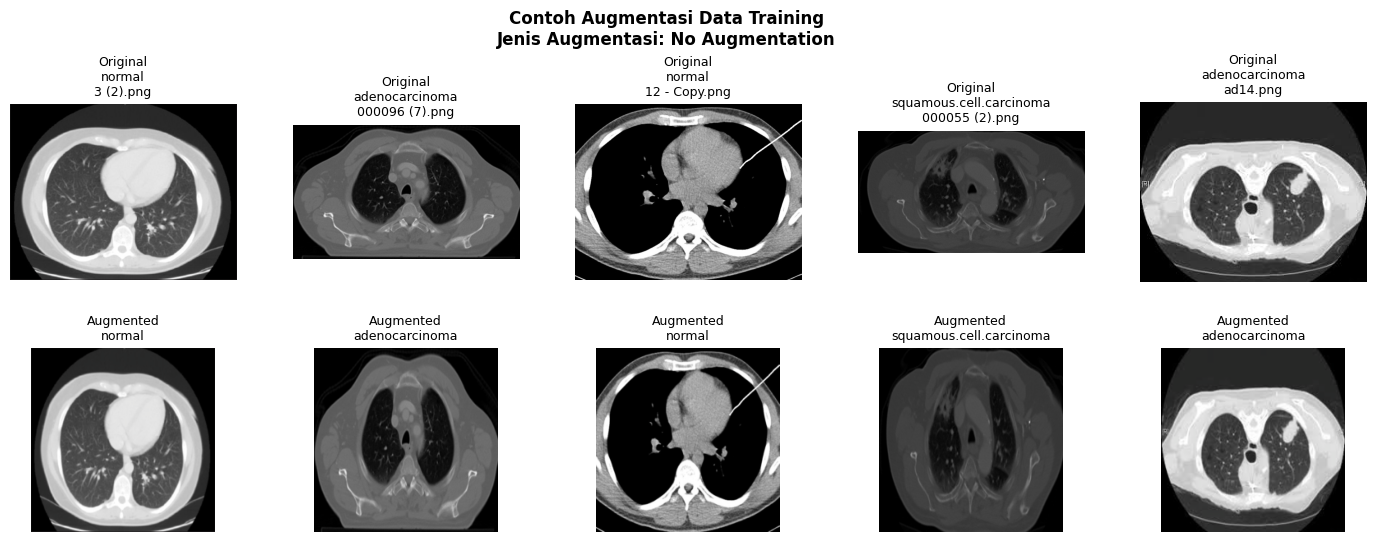

In [33]:
import matplotlib.pyplot as plt
import torch
import random  # ⬅️ tambahkan baris ini!
from torchvision import transforms
from PIL import Image

def detect_applied_augmentations(transform_pipeline):
    """Deteksi jenis augmentasi yang digunakan."""
    aug_list = []
    for t in transform_pipeline.transforms:
        name = t.__class__.__name__
        if "RandomRotation" in name:
            aug_list.append("Rotation")
        elif "RandomHorizontalFlip" in name:
            aug_list.append("Flip")
        elif "RandomAffine" in name:
            aug_list.append("Affine (Shift/Zoom)")
        elif "ColorJitter" in name:
            aug_list.append("Color Jitter")
        elif "RandomPerspective" in name:
            aug_list.append("Perspective")
        elif "RandomGrayscale" in name:
            aug_list.append("Grayscale")
        elif "RandomErasing" in name:
            aug_list.append("Erasing")
    return ", ".join(aug_list) if aug_list else "No Augmentation"


def visualize_multiple_augmentations_horizontal(dataset, num_pairs=5):
    """
    Menampilkan 5 pasangan gambar original dan hasil augmentasinya
    dengan layout horizontal: Original1 | Aug1 | Original2 | Aug2 ...
    """
    # Ambil sample acak sejumlah num_pairs
    indices = random.sample(range(len(dataset)), num_pairs)
    transform_pipeline = dataset.transform
    aug_types = detect_applied_augmentations(transform_pipeline)

    # Denormalisasi agar hasil augmentasi tampil natural
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )

    # Buat grid: 2 baris (Original + Augmented), kolom = num_pairs
    fig, axes = plt.subplots(2, num_pairs, figsize=(3.5 * num_pairs, 6))
    fig.suptitle(
        f"Contoh Augmentasi Data Training\nJenis Augmentasi: {aug_types}",
        fontsize=12, fontweight='bold'
    )

    for col, idx in enumerate(indices):
        img_path, label = dataset.samples[idx]
        class_name = list(dataset.class_to_idx.keys())[label]

        # Buka gambar original
        original_img = Image.open(img_path).convert("RGB")

        # Terapkan augmentasi
        aug_img, _ = dataset[idx]
        aug_img = inv_normalize(aug_img)
        aug_img = torch.clamp(aug_img, 0, 1).permute(1, 2, 0).numpy()

        # Baris pertama → Original
        axes[0, col].imshow(original_img)
        axes[0, col].set_title(f"Original\n{class_name}\n{img_path.split('/')[-1]}", fontsize=9)
        axes[0, col].axis("off")

        # Baris kedua → Augmented
        axes[1, col].imshow(aug_img)
        axes[1, col].set_title(f"Augmented\n{class_name}", fontsize=9)
        axes[1, col].axis("off")

    plt.subplots_adjust(wspace=0.25, hspace=0.35, top=0.83)
    plt.savefig("horizontal_augmentations.png", dpi=150, bbox_inches="tight")
    plt.show()

# 🔹 Jalankan fungsi
print("Visualisasi 5 gambar original vs hasil augmentasi (layout horizontal):")
visualize_multiple_augmentations_horizontal(train_dataset, num_pairs=5)

In [34]:
def estimate_effective_dataset_size(original_size, num_augmentations=15):
    """
    Estimasi effective dataset size dengan augmentasi.
    
    Args:
        original_size: Jumlah gambar asli
        num_augmentations: Estimasi jumlah variasi unik per gambar
    """
    effective_size = original_size * num_augmentations
    
    print("\n" + "="*70)
    print("ESTIMASI EFFECTIVE DATASET SIZE")
    print("="*70)
    print(f"Original training images    : {original_size}")
    print(f"Augmentation variations     : ~{num_augmentations}x per image")
    print(f"Effective dataset size      : ~{effective_size:,} unique variations")
    print(f"\nDengan augmentasi, model akan melihat variasi berbeda setiap epoch,")
    print(f"sehingga mengurangi overfitting meskipun dataset kecil.")

estimate_effective_dataset_size(len(train_dataset))


ESTIMASI EFFECTIVE DATASET SIZE
Original training images    : 538
Augmentation variations     : ~15x per image
Effective dataset size      : ~8,070 unique variations

Dengan augmentasi, model akan melihat variasi berbeda setiap epoch,
sehingga mengurangi overfitting meskipun dataset kecil.


# Training Model efficientformer_l3 VS efficientformerV2_s2

In [35]:
!pip install timm -q

import timm
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import autocast, GradScaler
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("✅ Using device:", device)

✅ Using device: cuda


In [36]:
EPOCHS = 50
WARMUP_EPOCHS = 5
LR_BASE = 2e-4
WEIGHT_DECAY = 1e-4
TRANSFER_STRATEGY = 'full'  # full fine-tuning
PRETRAINED = True
OUTPUT_DIR = '/kaggle/working/efficientformer'
os.makedirs(OUTPUT_DIR, exist_ok=True)

num_classes = len(train_dataset.classes)
print("Detected classes:", train_dataset.classes)

Detected classes: ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']


In [37]:
def train_one_epoch(model, loader, optimizer, criterion, device, scaler, epoch):
    model.train()
    running_loss = 0.0
    preds, targets = [], []
    loop = tqdm(loader, desc=f"Train E{epoch}", leave=False)

    for imgs, labels in loop:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        if device.type == 'cuda':
            ctx = torch.amp.autocast('cuda')
        else:
            from contextlib import nullcontext
            ctx = nullcontext()

        with ctx:
            outputs = model(imgs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * imgs.size(0)
        preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        targets.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(loader.dataset)
    acc = accuracy_score(targets, preds)
    return avg_loss, acc


def validate_one_epoch(model, loader, criterion, device, epoch):
    model.eval()
    running_loss = 0.0
    preds, targets = [], []

    with torch.no_grad():
        loop = tqdm(loader, desc=f"Val E{epoch}", leave=False)
        for imgs, labels in loop:
            imgs, labels = imgs.to(device), labels.to(device)

            if device.type == 'cuda':
                ctx = torch.amp.autocast('cuda')
            else:
                from contextlib import nullcontext
                ctx = nullcontext()

            with ctx:
                outputs = model(imgs)
                loss = criterion(outputs, labels)

            running_loss += loss.item() * imgs.size(0)
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            targets.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(loader.dataset)
    acc = accuracy_score(targets, preds)
    return avg_loss, acc

In [38]:
import json

def train_model(model_name, train_loader, val_loader):
    print(f"\n🚀 Training model: {model_name} (tanpa augmentasi)\n")

    model = timm.create_model(model_name, pretrained=PRETRAINED, num_classes=num_classes)
    model.to(device)

    # Atur fine-tuning strategy
    FROZEN_EXCLUDE_KEYWORDS = ['head', 'classifier', 'fc']
    if TRANSFER_STRATEGY == 'freeze_head':
        for name, p in model.named_parameters():
            p.requires_grad = False
            if any(k in name.lower() for k in FROZEN_EXCLUDE_KEYWORDS):
                p.requires_grad = True
        print("Strategy: freeze_head → hanya head/classifier yang dilatih.")
    elif TRANSFER_STRATEGY == 'partial':
        params = list(model.named_parameters())
        cutoff = int(len(params) * 0.7)
        for idx, (name, p) in enumerate(params):
            p.requires_grad = False if idx < cutoff else True
        print("Strategy: partial fine-tune → layer awal dibekukan, layer akhir dilatih.")
    else:  # full
        for p in model.parameters():
            p.requires_grad = True
        print("Strategy: full fine-tune → semua parameter dilatih.")

    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    optimizer = AdamW(model.parameters(), lr=LR_BASE, weight_decay=WEIGHT_DECAY)
    scheduler = CosineAnnealingLR(optimizer, T_max=max(1, EPOCHS - WARMUP_EPOCHS), eta_min=1e-6)
    scaler = torch.cuda.amp.GradScaler()

    best_val_loss = float('inf')
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(1, EPOCHS + 1):
        if epoch <= WARMUP_EPOCHS:
            warmup_factor = epoch / float(WARMUP_EPOCHS)
            for g in optimizer.param_groups:
                g['lr'] = LR_BASE * warmup_factor

        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device, scaler, epoch)
        if epoch > WARMUP_EPOCHS:
            scheduler.step()
        val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device, epoch)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch:02d}: Train Acc={train_acc:.4f} | Val Acc={val_acc:.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, f'best_{model_name}_NoAug.pth'))
            print(f"✅ Model terbaik {model_name} disimpan.")

    print(f"Training selesai untuk {model_name}. Best val_loss: {best_val_loss:.4f}\n")

    # =============== SAVE JSON HISTORY ===============
    history_path = os.path.join(OUTPUT_DIR, f"history_{model_name}_NoAug.json")

    with open(history_path, "w") as f:
        json.dump(history, f, indent=4)

    print(f"📁 History training disimpan ke {history_path}")

    return history

# =============================
# 6️⃣ Jalankan Training
# =============================
hist_v1_aug = train_model('efficientformer_l3', train_loader, val_loader)
hist_v1_aug = train_model('efficientformerv2_s2', train_loader, val_loader)


🚀 Training model: efficientformer_l3 (tanpa augmentasi)

Strategy: full fine-tune → semua parameter dilatih.


/tmp/ipykernel_170/1722147744.py:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Train E1:   0%|          | 0/16 [00:00<?, ?it/s]

Val E1:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 01: Train Acc=0.4395 | Val Acc=0.4161
✅ Model terbaik efficientformer_l3 disimpan.


Train E2:   0%|          | 0/16 [00:00<?, ?it/s]

Val E2:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 02: Train Acc=0.6953 | Val Acc=0.6058
✅ Model terbaik efficientformer_l3 disimpan.


Train E3:   0%|          | 0/16 [00:00<?, ?it/s]

Val E3:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 03: Train Acc=0.8887 | Val Acc=0.7810
✅ Model terbaik efficientformer_l3 disimpan.


Train E4:   0%|          | 0/16 [00:00<?, ?it/s]

Val E4:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 04: Train Acc=0.9727 | Val Acc=0.9051
✅ Model terbaik efficientformer_l3 disimpan.


Train E5:   0%|          | 0/16 [00:00<?, ?it/s]

Val E5:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 05: Train Acc=0.9961 | Val Acc=0.9416
✅ Model terbaik efficientformer_l3 disimpan.


Train E6:   0%|          | 0/16 [00:00<?, ?it/s]

Val E6:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 06: Train Acc=0.9961 | Val Acc=0.9708
✅ Model terbaik efficientformer_l3 disimpan.


Train E7:   0%|          | 0/16 [00:00<?, ?it/s]

Val E7:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 07: Train Acc=1.0000 | Val Acc=0.9708


Train E8:   0%|          | 0/16 [00:00<?, ?it/s]

Val E8:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 08: Train Acc=1.0000 | Val Acc=0.9562


Train E9:   0%|          | 0/16 [00:00<?, ?it/s]

Val E9:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 09: Train Acc=1.0000 | Val Acc=0.9562


Train E10:   0%|          | 0/16 [00:00<?, ?it/s]

Val E10:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10: Train Acc=0.9980 | Val Acc=0.9343


Train E11:   0%|          | 0/16 [00:00<?, ?it/s]

Val E11:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 11: Train Acc=0.9980 | Val Acc=0.9562


Train E12:   0%|          | 0/16 [00:00<?, ?it/s]

Val E12:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 12: Train Acc=0.9941 | Val Acc=0.9489


Train E13:   0%|          | 0/16 [00:00<?, ?it/s]

Val E13:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 13: Train Acc=0.9980 | Val Acc=0.9489


Train E14:   0%|          | 0/16 [00:00<?, ?it/s]

Val E14:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 14: Train Acc=0.9922 | Val Acc=0.9635


Train E15:   0%|          | 0/16 [00:00<?, ?it/s]

Val E15:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 15: Train Acc=0.9980 | Val Acc=0.9708
✅ Model terbaik efficientformer_l3 disimpan.


Train E16:   0%|          | 0/16 [00:00<?, ?it/s]

Val E16:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 16: Train Acc=0.9980 | Val Acc=0.9635


Train E17:   0%|          | 0/16 [00:00<?, ?it/s]

Val E17:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 17: Train Acc=1.0000 | Val Acc=0.9635


Train E18:   0%|          | 0/16 [00:00<?, ?it/s]

Val E18:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 18: Train Acc=0.9922 | Val Acc=0.9635


Train E19:   0%|          | 0/16 [00:00<?, ?it/s]

Val E19:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 19: Train Acc=0.9941 | Val Acc=0.9708


Train E20:   0%|          | 0/16 [00:00<?, ?it/s]

Val E20:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 20: Train Acc=0.9961 | Val Acc=0.9635


Train E21:   0%|          | 0/16 [00:00<?, ?it/s]

Val E21:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 21: Train Acc=0.9961 | Val Acc=0.9635


Train E22:   0%|          | 0/16 [00:00<?, ?it/s]

Val E22:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 22: Train Acc=0.9980 | Val Acc=0.9708


Train E23:   0%|          | 0/16 [00:00<?, ?it/s]

Val E23:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 23: Train Acc=0.9961 | Val Acc=0.9635


Train E24:   0%|          | 0/16 [00:00<?, ?it/s]

Val E24:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 24: Train Acc=0.9961 | Val Acc=0.9635


Train E25:   0%|          | 0/16 [00:00<?, ?it/s]

Val E25:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 25: Train Acc=1.0000 | Val Acc=0.9635


Train E26:   0%|          | 0/16 [00:00<?, ?it/s]

Val E26:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 26: Train Acc=0.9922 | Val Acc=0.9635


Train E27:   0%|          | 0/16 [00:00<?, ?it/s]

Val E27:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 27: Train Acc=0.9961 | Val Acc=0.9635


Train E28:   0%|          | 0/16 [00:00<?, ?it/s]

Val E28:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 28: Train Acc=0.9980 | Val Acc=0.9635


Train E29:   0%|          | 0/16 [00:00<?, ?it/s]

Val E29:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 29: Train Acc=1.0000 | Val Acc=0.9635


Train E30:   0%|          | 0/16 [00:00<?, ?it/s]

Val E30:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 30: Train Acc=0.9961 | Val Acc=0.9635


Train E31:   0%|          | 0/16 [00:00<?, ?it/s]

Val E31:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 31: Train Acc=1.0000 | Val Acc=0.9635


Train E32:   0%|          | 0/16 [00:00<?, ?it/s]

Val E32:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 32: Train Acc=0.9941 | Val Acc=0.9635


Train E33:   0%|          | 0/16 [00:00<?, ?it/s]

Val E33:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 33: Train Acc=0.9980 | Val Acc=0.9635


Train E34:   0%|          | 0/16 [00:00<?, ?it/s]

Val E34:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 34: Train Acc=0.9980 | Val Acc=0.9635


Train E35:   0%|          | 0/16 [00:00<?, ?it/s]

Val E35:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 35: Train Acc=0.9980 | Val Acc=0.9635


Train E36:   0%|          | 0/16 [00:00<?, ?it/s]

Val E36:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 36: Train Acc=0.9980 | Val Acc=0.9635


Train E37:   0%|          | 0/16 [00:00<?, ?it/s]

Val E37:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 37: Train Acc=0.9961 | Val Acc=0.9635


Train E38:   0%|          | 0/16 [00:00<?, ?it/s]

Val E38:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 38: Train Acc=0.9961 | Val Acc=0.9635


Train E39:   0%|          | 0/16 [00:00<?, ?it/s]

Val E39:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 39: Train Acc=0.9980 | Val Acc=0.9635


Train E40:   0%|          | 0/16 [00:00<?, ?it/s]

Val E40:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 40: Train Acc=0.9980 | Val Acc=0.9635


Train E41:   0%|          | 0/16 [00:00<?, ?it/s]

Val E41:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 41: Train Acc=1.0000 | Val Acc=0.9635


Train E42:   0%|          | 0/16 [00:00<?, ?it/s]

Val E42:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 42: Train Acc=0.9980 | Val Acc=0.9635


Train E43:   0%|          | 0/16 [00:00<?, ?it/s]

Val E43:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 43: Train Acc=0.9980 | Val Acc=0.9635


Train E44:   0%|          | 0/16 [00:00<?, ?it/s]

Val E44:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 44: Train Acc=1.0000 | Val Acc=0.9635


Train E45:   0%|          | 0/16 [00:00<?, ?it/s]

Val E45:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 45: Train Acc=0.9980 | Val Acc=0.9635


Train E46:   0%|          | 0/16 [00:00<?, ?it/s]

Val E46:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 46: Train Acc=1.0000 | Val Acc=0.9635


Train E47:   0%|          | 0/16 [00:00<?, ?it/s]

Val E47:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 47: Train Acc=0.9980 | Val Acc=0.9635


Train E48:   0%|          | 0/16 [00:00<?, ?it/s]

Val E48:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 48: Train Acc=1.0000 | Val Acc=0.9635


Train E49:   0%|          | 0/16 [00:00<?, ?it/s]

Val E49:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 49: Train Acc=0.9961 | Val Acc=0.9635


Train E50:   0%|          | 0/16 [00:00<?, ?it/s]

Val E50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 50: Train Acc=1.0000 | Val Acc=0.9635
Training selesai untuk efficientformer_l3. Best val_loss: 0.1173

📁 History training disimpan ke /kaggle/working/efficientformer/history_efficientformer_l3_NoAug.json

🚀 Training model: efficientformerv2_s2 (tanpa augmentasi)

Strategy: full fine-tune → semua parameter dilatih.


/tmp/ipykernel_170/1722147744.py:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Train E1:   0%|          | 0/16 [00:00<?, ?it/s]

Val E1:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 01: Train Acc=0.3887 | Val Acc=0.2774
✅ Model terbaik efficientformerv2_s2 disimpan.


Train E2:   0%|          | 0/16 [00:00<?, ?it/s]

Val E2:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 02: Train Acc=0.6523 | Val Acc=0.5328


Train E3:   0%|          | 0/16 [00:00<?, ?it/s]

Val E3:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 03: Train Acc=0.6699 | Val Acc=0.5474
✅ Model terbaik efficientformerv2_s2 disimpan.


Train E4:   0%|          | 0/16 [00:00<?, ?it/s]

Val E4:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 04: Train Acc=0.7520 | Val Acc=0.6204


Train E5:   0%|          | 0/16 [00:00<?, ?it/s]

Val E5:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 05: Train Acc=0.8867 | Val Acc=0.8248


Train E6:   0%|          | 0/16 [00:00<?, ?it/s]

Val E6:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 06: Train Acc=0.9355 | Val Acc=0.7007


Train E7:   0%|          | 0/16 [00:00<?, ?it/s]

Val E7:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 07: Train Acc=0.9668 | Val Acc=0.8905


Train E8:   0%|          | 0/16 [00:00<?, ?it/s]

Val E8:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 08: Train Acc=0.9727 | Val Acc=0.8540


Train E9:   0%|          | 0/16 [00:00<?, ?it/s]

Val E9:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 09: Train Acc=0.9727 | Val Acc=0.8759
✅ Model terbaik efficientformerv2_s2 disimpan.


Train E10:   0%|          | 0/16 [00:00<?, ?it/s]

Val E10:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 10: Train Acc=0.9922 | Val Acc=0.9051


Train E11:   0%|          | 0/16 [00:00<?, ?it/s]

Val E11:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 11: Train Acc=0.9844 | Val Acc=0.9562
✅ Model terbaik efficientformerv2_s2 disimpan.


Train E12:   0%|          | 0/16 [00:00<?, ?it/s]

Val E12:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 12: Train Acc=0.9922 | Val Acc=0.9270


Train E13:   0%|          | 0/16 [00:00<?, ?it/s]

Val E13:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 13: Train Acc=0.9922 | Val Acc=0.9270


Train E14:   0%|          | 0/16 [00:00<?, ?it/s]

Val E14:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 14: Train Acc=0.9883 | Val Acc=0.9489
✅ Model terbaik efficientformerv2_s2 disimpan.


Train E15:   0%|          | 0/16 [00:00<?, ?it/s]

Val E15:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 15: Train Acc=0.9941 | Val Acc=0.9343


Train E16:   0%|          | 0/16 [00:00<?, ?it/s]

Val E16:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 16: Train Acc=0.9863 | Val Acc=0.9343


Train E17:   0%|          | 0/16 [00:00<?, ?it/s]

Val E17:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 17: Train Acc=0.9980 | Val Acc=0.9343


Train E18:   0%|          | 0/16 [00:00<?, ?it/s]

Val E18:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 18: Train Acc=0.9941 | Val Acc=0.9635


Train E19:   0%|          | 0/16 [00:00<?, ?it/s]

Val E19:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 19: Train Acc=0.9961 | Val Acc=0.9562


Train E20:   0%|          | 0/16 [00:00<?, ?it/s]

Val E20:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 20: Train Acc=0.9961 | Val Acc=0.9781
✅ Model terbaik efficientformerv2_s2 disimpan.


Train E21:   0%|          | 0/16 [00:00<?, ?it/s]

Val E21:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 21: Train Acc=0.9980 | Val Acc=0.9562


Train E22:   0%|          | 0/16 [00:00<?, ?it/s]

Val E22:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 22: Train Acc=0.9863 | Val Acc=0.8686


Train E23:   0%|          | 0/16 [00:00<?, ?it/s]

Val E23:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 23: Train Acc=0.9863 | Val Acc=0.9051


Train E24:   0%|          | 0/16 [00:00<?, ?it/s]

Val E24:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 24: Train Acc=0.9941 | Val Acc=0.9635


Train E25:   0%|          | 0/16 [00:00<?, ?it/s]

Val E25:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 25: Train Acc=1.0000 | Val Acc=0.9489


Train E26:   0%|          | 0/16 [00:00<?, ?it/s]

Val E26:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 26: Train Acc=0.9941 | Val Acc=0.9270


Train E27:   0%|          | 0/16 [00:00<?, ?it/s]

Val E27:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 27: Train Acc=1.0000 | Val Acc=0.9270


Train E28:   0%|          | 0/16 [00:00<?, ?it/s]

Val E28:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 28: Train Acc=0.9980 | Val Acc=0.9489


Train E29:   0%|          | 0/16 [00:00<?, ?it/s]

Val E29:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 29: Train Acc=0.9961 | Val Acc=0.9343


Train E30:   0%|          | 0/16 [00:00<?, ?it/s]

Val E30:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 30: Train Acc=0.9941 | Val Acc=0.9343


Train E31:   0%|          | 0/16 [00:00<?, ?it/s]

Val E31:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 31: Train Acc=0.9961 | Val Acc=0.9124


Train E32:   0%|          | 0/16 [00:00<?, ?it/s]

Val E32:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 32: Train Acc=0.9922 | Val Acc=0.9416


Train E33:   0%|          | 0/16 [00:00<?, ?it/s]

Val E33:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 33: Train Acc=0.9980 | Val Acc=0.9270


Train E34:   0%|          | 0/16 [00:00<?, ?it/s]

Val E34:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 34: Train Acc=0.9980 | Val Acc=0.9270


Train E35:   0%|          | 0/16 [00:00<?, ?it/s]

Val E35:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 35: Train Acc=0.9980 | Val Acc=0.9416


Train E36:   0%|          | 0/16 [00:00<?, ?it/s]

Val E36:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 36: Train Acc=1.0000 | Val Acc=0.9562


Train E37:   0%|          | 0/16 [00:00<?, ?it/s]

Val E37:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 37: Train Acc=0.9961 | Val Acc=0.9416


Train E38:   0%|          | 0/16 [00:00<?, ?it/s]

Val E38:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 38: Train Acc=0.9980 | Val Acc=0.9124


Train E39:   0%|          | 0/16 [00:00<?, ?it/s]

Val E39:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 39: Train Acc=0.9961 | Val Acc=0.9489


Train E40:   0%|          | 0/16 [00:00<?, ?it/s]

Val E40:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 40: Train Acc=0.9980 | Val Acc=0.9635


Train E41:   0%|          | 0/16 [00:00<?, ?it/s]

Val E41:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 41: Train Acc=1.0000 | Val Acc=0.9562


Train E42:   0%|          | 0/16 [00:00<?, ?it/s]

Val E42:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 42: Train Acc=1.0000 | Val Acc=0.9489


Train E43:   0%|          | 0/16 [00:00<?, ?it/s]

Val E43:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 43: Train Acc=0.9922 | Val Acc=0.9416


Train E44:   0%|          | 0/16 [00:00<?, ?it/s]

Val E44:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 44: Train Acc=0.9922 | Val Acc=0.9489


Train E45:   0%|          | 0/16 [00:00<?, ?it/s]

Val E45:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 45: Train Acc=0.9980 | Val Acc=0.9489


Train E46:   0%|          | 0/16 [00:00<?, ?it/s]

Val E46:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 46: Train Acc=1.0000 | Val Acc=0.9489


Train E47:   0%|          | 0/16 [00:00<?, ?it/s]

Val E47:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 47: Train Acc=0.9980 | Val Acc=0.9562


Train E48:   0%|          | 0/16 [00:00<?, ?it/s]

Val E48:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 48: Train Acc=0.9941 | Val Acc=0.9416


Train E49:   0%|          | 0/16 [00:00<?, ?it/s]

Val E49:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 49: Train Acc=0.9980 | Val Acc=0.9562


Train E50:   0%|          | 0/16 [00:00<?, ?it/s]

Val E50:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 50: Train Acc=0.9980 | Val Acc=0.9635
Training selesai untuk efficientformerv2_s2. Best val_loss: 0.1100

📁 History training disimpan ke /kaggle/working/efficientformer/history_efficientformerv2_s2_NoAug.json


# Evaluasi Model

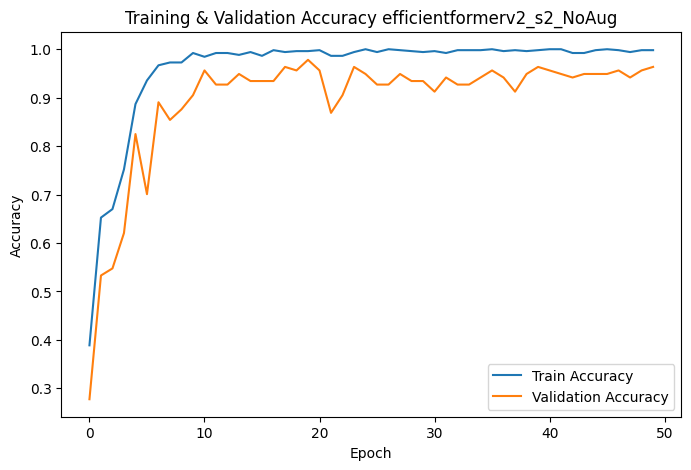

✅ Final Train Accuracy: 0.9980
✅ Final Validation Accuracy: 0.9635


In [43]:
import json
import matplotlib.pyplot as plt

# Path history
history_path = '/kaggle/working/efficientformer/history_efficientformerv2_s2_NoAug.json'

with open(history_path, 'r') as f:
    history = json.load(f)

# Plot training & validation accuracy
plt.figure(figsize=(8,5))
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy efficientformerv2_s2_NoAug')
plt.legend()
plt.show()

# Print final accuracy
print(f"✅ Final Train Accuracy: {history['train_acc'][-1]:.4f}")
print(f"✅ Final Validation Accuracy: {history['val_acc'][-1]:.4f}")


✅ Overall Accuracy: 96.35%

📄 Classification Report:
                         precision    recall  f1-score   support

         adenocarcinoma       0.98      0.91      0.94        44
   large.cell.carcinoma       0.93      0.96      0.95        28
                 normal       1.00      1.00      1.00        31
squamous.cell.carcinoma       0.94      1.00      0.97        34

               accuracy                           0.96       137
              macro avg       0.96      0.97      0.96       137
           weighted avg       0.96      0.96      0.96       137



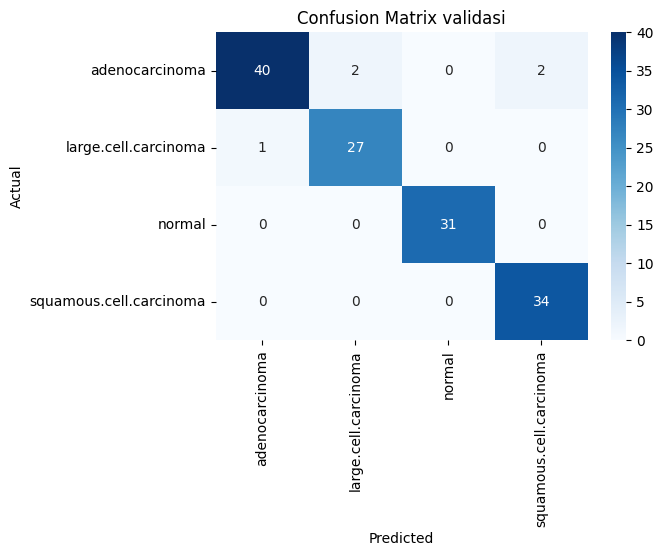

In [44]:
import timm
import torch
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_classes = len(val_dataset.classes)  # atau test_dataset
model = timm.create_model('efficientformerv2_s2', pretrained=False, num_classes=num_classes)
model.load_state_dict(torch.load('/kaggle/working/efficientformer/best_efficientformerv2_s2_NoAug.pth', map_location=device))
model.to(device)
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for imgs, labels in val_loader:  # bisa ganti test_loader
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(all_labels, all_preds)
print(f"\n✅ Overall Accuracy: {accuracy*100:.2f}%")

# Classification report
print("\n📄 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=val_dataset.classes))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=val_dataset.classes, yticklabels=val_dataset.classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix validasi')
plt.show()

In [45]:
import torch
from torchvision import datasets, transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Transformasi yang sama dengan training (resize, normalize)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # sesuaikan ukuran input model
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# Dataset test
test_dataset = datasets.ImageFolder('/kaggle/input/chest-ctscan-images/Data/test',
                                    transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

Using device: cuda


In [46]:
import timm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def evaluate_model_clean(model_name, model_path, data_loader, device, plot_cm=True):
    """
    Load model dari file .pth dan evaluasi pada data_loader.
    Menampilkan hasil rapi seperti contoh.
    """
    # Load model
    num_classes = len(data_loader.dataset.classes)
    model = timm.create_model(model_name, pretrained=False, num_classes=num_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    
    print(f"✅ Model '{model_name}' dimuat untuk evaluasi test set.\n")
    
    # Inference
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Accuracy
    acc = accuracy_score(all_labels, all_preds)
    print(f"🎯 Test Accuracy: {acc:.4f}\n")
    
    # Classification report
    report = classification_report(all_labels, all_preds, target_names=data_loader.dataset.classes)
    print("Classification Report:")
    print(report)
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)
    
    if plot_cm:
        plt.figure(figsize=(6,5))
        df_cm = pd.DataFrame(cm, index=data_loader.dataset.classes, columns=data_loader.dataset.classes)
        sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.title(f'Confusion Matrix - {model_name}')
        plt.show()
    
    return acc, report, cm

✅ Model 'efficientformer_l3' dimuat untuk evaluasi test set.

🎯 Test Accuracy: 0.9206

Classification Report:
                         precision    recall  f1-score   support

         adenocarcinoma       0.91      0.88      0.90       120
   large.cell.carcinoma       0.90      0.92      0.91        51
                 normal       1.00      0.98      0.99        54
squamous.cell.carcinoma       0.89      0.93      0.91        90

               accuracy                           0.92       315
              macro avg       0.93      0.93      0.93       315
           weighted avg       0.92      0.92      0.92       315

Confusion Matrix:
[[106   4   0  10]
 [  4  47   0   0]
 [  0   1  53   0]
 [  6   0   0  84]]


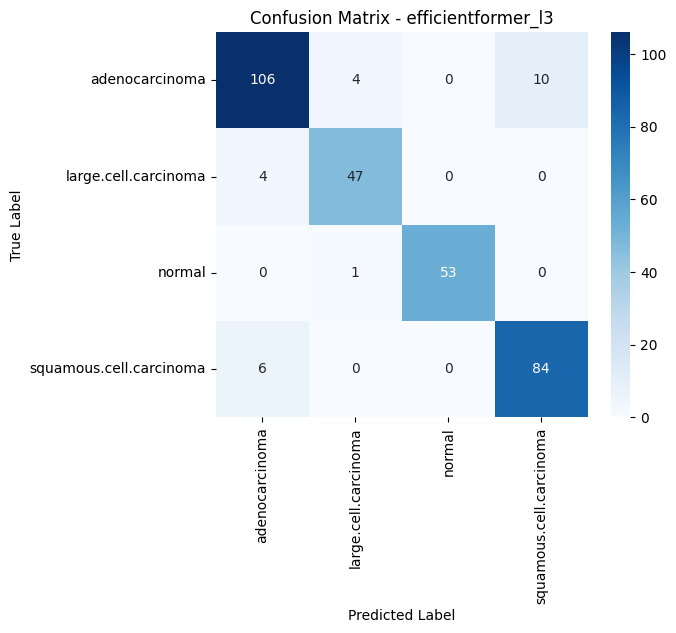

✅ Model 'efficientformerv2_s2' dimuat untuk evaluasi test set.

🎯 Test Accuracy: 0.8794

Classification Report:
                         precision    recall  f1-score   support

         adenocarcinoma       0.92      0.81      0.86       120
   large.cell.carcinoma       0.63      1.00      0.77        51
                 normal       1.00      0.96      0.98        54
squamous.cell.carcinoma       1.00      0.86      0.92        90

               accuracy                           0.88       315
              macro avg       0.89      0.91      0.88       315
           weighted avg       0.91      0.88      0.89       315

Confusion Matrix:
[[97 23  0  0]
 [ 0 51  0  0]
 [ 1  1 52  0]
 [ 7  6  0 77]]


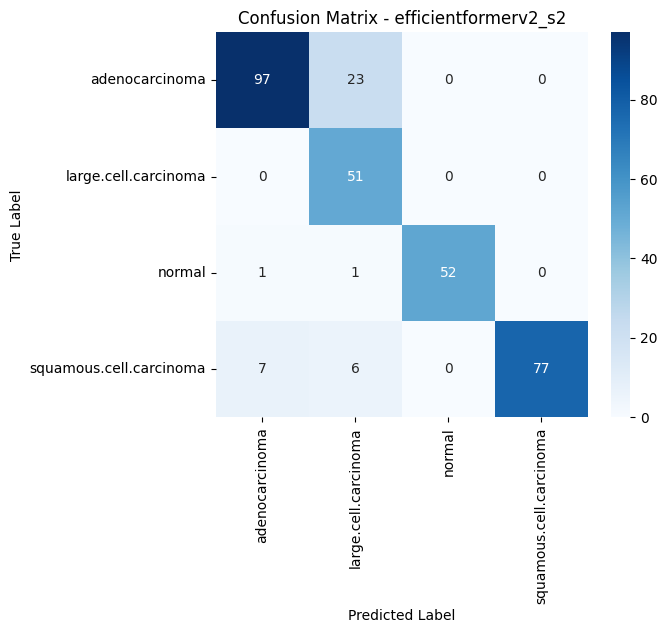

In [47]:
# EfficientFormer V1
acc_v1, report_v1, cm_v1 = evaluate_model_clean(
    'efficientformer_l3',
    '/kaggle/working/efficientformer/best_efficientformer_l3_NoAug.pth',
    test_loader,
    device
)

# EfficientFormer V2
acc_v2, report_v2, cm_v2 = evaluate_model_clean(
    'efficientformerv2_s2',
    '/kaggle/working/efficientformer/best_efficientformerv2_s2_NoAug.pth',
    test_loader,
    device
)

In [32]:
import json
import os

# Folder output model
OUTPUT_DIR = '/kaggle/working/efficientformer_withAugment'

# Variabel global (sama seperti yang digunakan saat training)
PRETRAINED = True
TRANSFER_STRATEGY = 'full'  # misal full fine-tune
EPOCHS = 50
WARMUP_EPOCHS = 5
LR_BASE = 2e-4
WEIGHT_DECAY = 1e-4
BATCH_SIZE = 32
NUM_CLASSES = 4
FROZEN_EXCLUDE_KEYWORDS = ['head', 'classifier', 'fc']
DEVICE = 'cuda'  # atau 'cpu' sesuai setup

# Nama model dan file .pth yang ada di folder
model_files = [f for f in os.listdir(OUTPUT_DIR) if f.endswith('.pth')]

# Buat dict config
config_aug = {
    "models": {},
    "pretrained": PRETRAINED,
    "transfer_strategy": TRANSFER_STRATEGY,
    "epochs": EPOCHS,
    "warmup_epochs": WARMUP_EPOCHS,
    "learning_rate": LR_BASE,
    "weight_decay": WEIGHT_DECAY,
    "optimizer": "AdamW",
    "scheduler": "CosineAnnealingLR",
    "batch_size": BATCH_SIZE,
    "num_classes": NUM_CLASSES,
    "frozen_exclude_keywords": FROZEN_EXCLUDE_KEYWORDS,
    "device": DEVICE,
    "augmentation": True,
    "train_transform": [
        "Resize(224,224)",
        "RandomHorizontalFlip(0.5)",
        "RandomRotation(15)",
        "ColorJitter(brightness=0.1, contrast=0.1)",
        "RandomAffine(degrees=0, translate=(0.1,0.1))",
        "ToTensor",
        "Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])"
    ]
}

# Masukkan info file .pth per model
for model_file in model_files:
    model_name = model_file.replace('.pth','')
    config_aug["models"][model_name] = os.path.join(OUTPUT_DIR, model_file)

# Simpan sebagai JSON
config_path = os.path.join(OUTPUT_DIR, "training_config_aug.json")
with open(config_path, "w") as f:
    json.dump(config_aug, f, indent=4)

print(f"✅ Config training augmentasi disimpan di {config_path}")

✅ Config training augmentasi disimpan di /kaggle/working/efficientformer_withAugment/training_config_aug.json


# Grad-Cam

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms
from PIL import Image
import timm
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [26]:
model_paths = {
    "EfficientFormer-L3 (Augment)": "/kaggle/input/augmentasi/pytorch/default/1/best_efficientformer_l3_aug.pth",
    "EfficientFormerV2-S2 (Augment)": "/kaggle/input/augmentasi/pytorch/default/1/best_efficientformerv2_s2_aug.pth",
}

MODEL_NAMES = {
    "EfficientFormer-L3 (Augment)": "efficientformer_l3",
    "EfficientFormerV2-S2 (Augment)": "efficientformerv2_s2",
}

num_classes = 4
class_names = ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']


In [27]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer

        self.gradients = None
        self.activations = None

        # hook untuk menangkap gradien dan feature map
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = torch.argmax(output).item()

        # backward untuk target class
        self.model.zero_grad()
        target = output[0, class_idx]
        target.backward()

        # hitung gradcam
        grads = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (grads * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)

        # normalisasi
        cam = cam - cam.min()
        cam = cam / cam.max()
        return cam[0, 0].cpu().numpy(), class_idx

def show_gradcam_on_image(img_path, model_name, model_path):
    print(f"\n🔍 Generating Grad-CAM for {model_name}...")

    # Preprocess gambar
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

    img = Image.open(img_path).convert('RGB')
    input_tensor = transform(img).unsqueeze(0).to(device)

    # Load model
    model = timm.create_model(MODEL_NAMES[model_name], pretrained=False, num_classes=num_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval().to(device)

    # Tentukan target layer (ambil layer konvolusi terakhir)
    target_layer = None
    for name, module in list(model.named_modules())[::-1]:  # ✅ FIX: ubah ke list sebelum dibalik
        if isinstance(module, torch.nn.Conv2d):
            target_layer = module
            break

    if target_layer is None:
        raise ValueError("❌ Tidak ditemukan layer Conv2d di model untuk GradCAM.")

    # Inisialisasi GradCAM
    gradcam = GradCAM(model, target_layer)
    cam, class_idx = gradcam.generate(input_tensor)

    # Visualisasi
    img_np = np.array(img.resize((224, 224)))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(heatmap, 0.5, img_np, 0.5, 0)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(img_np)
    plt.title("Original Image")

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap)
    plt.title(f"Grad-CAM Heatmap ({class_names[class_idx]})")

    plt.subplot(1, 3, 3)
    plt.imshow(superimposed)
    plt.title("Superimposed Result")
    plt.show()


In [ ]:
test_img_path = "/kaggle/input/chest-ctscan-images/Data/test/squamous.cell.carcinoma/000112.png"

for model_name, model_path in model_paths.items():
    show_gradcam_on_image(test_img_path, model_name, model_path)

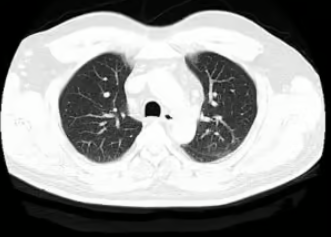

🔎 Gambar asli ditampilkan di atas.


🔍 Menguji model: EfficientFormer_L3_Aug
📸 Gambar: Screenshot 2025-11-11 094423.png
🧠 Prediksi: adenocarcinoma
📊 Probabilitas per kelas:
   - adenocarcinoma           : 99.92%
   - large.cell.carcinoma     : 0.00%
   - normal                   : 0.02%
   - squamous.cell.carcinoma  : 0.06%

🔍 Menguji model: EfficientFormerV2_S2_Aug
📸 Gambar: Screenshot 2025-11-11 094423.png
🧠 Prediksi: normal
📊 Probabilitas per kelas:
   - adenocarcinoma           : 16.63%
   - large.cell.carcinoma     : 25.72%
   - normal                   : 50.84%
   - squamous.cell.carcinoma  : 6.81%


In [32]:
import torch
import torch.nn.functional as F
import timm
from torchvision import transforms
from PIL import Image
import os

# ================================================================
# Konfigurasi Awal
# ================================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL_NAMES = {
    "EfficientFormer_L3_Aug": "efficientformer_l3",
    "EfficientFormerV2_S2_Aug": "efficientformerv2_s2"
}

MODEL_PATHS = {
    "EfficientFormer_L3_Aug": "/kaggle/input/augmentasi/pytorch/default/1/best_efficientformer_l3_aug.pth",
    "EfficientFormerV2_S2_Aug": "/kaggle/input/augmentasi/pytorch/default/1/best_efficientformerv2_s2_aug.pth"
}

# Kelas (harus sama urutannya seperti di train_dataset.class_to_idx)
class_names = ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']

# Path gambar test (ubah sesuai file test kamu)
test_img_path = "/kaggle/input/test-2/Screenshot 2025-11-11 094423.png"

# ================================================================
# Transformasi Input
# ================================================================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Load gambar dan konversi ke tensor
img = Image.open(test_img_path).convert("RGB")
input_tensor = transform(img).unsqueeze(0).to(device)

# ================================================================
# Fungsi Prediksi
# ================================================================
def predict_image(model_name, model_path):
    print(f"\n🔍 Menguji model: {model_name}")
    model = timm.create_model(MODEL_NAMES[model_name], pretrained=False, num_classes=len(class_names))
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    with torch.no_grad():
        outputs = model(input_tensor)
        probs = F.softmax(outputs, dim=1)[0]
        pred_idx = torch.argmax(probs).item()
        pred_class = class_names[pred_idx]

    print(f"📸 Gambar: {os.path.basename(test_img_path)}")
    print(f"🧠 Prediksi: {pred_class}")
    print("📊 Probabilitas per kelas:")
    for i, cls in enumerate(class_names):
        print(f"   - {cls:25s}: {probs[i]*100:.2f}%")

    return pred_class, probs.cpu().numpy()

# ================================================================
# Jalankan Prediksi untuk Kedua Model
# ================================================================
from IPython.display import display

display(img)
print(f"🔎 Gambar asli ditampilkan di atas.\n")

for name, path in MODEL_PATHS.items():
    predict_image(name, path)
